In [1]:
from sys import path
path.append('..')
from clearsky.main import StatisticalClearSky, IterativeClearSky
from clearsky.utilities import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from time import time
from datetime import datetime
from os.path import expanduser
from scipy.interpolate import interp1d
from scipy.stats import kstest

In [2]:
def threshold(alpha, n1, n2):
    c1 = np.sqrt(-0.5 * np.log(alpha / 2.))
    c2 = np.sqrt((n1 + n2) * 1. / (n1 * n2))
    return c1 * c2

In [3]:
def reverseThreshold(D, n1, n2):
    c2 = np.sqrt((n1 + n2) * 1. / (n1 * n2))
    return 2 * np.exp(-2 * (D / c2)**2)

## S47 - 6 months of data

In [4]:
ti = time()
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADHC1036570')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)
df = make_time_series(df, return_keys=False).fillna(0)
days = df.resample('D').max().index[1:-1]
start = days[0].strftime('%m/%d/%y')
end = days[-1].strftime('%m/%d/%y')
tf = time()
print start, end
print 'data loading took {:.2f} seconds'.format(tf-ti)

04/10/15 05/21/18
data loading took 5.67 seconds


In [5]:
p = df.loc[start:end].as_matrix()
D = df.loc[start:end].as_matrix().reshape(288, -1, order='F')[:, :365/2]

In [6]:
D.shape

(288, 182)

In [7]:
ics = IterativeClearSky(D, k=5, reserve_test_data=0.1)

In [8]:
ics.test_days

array([  8,  15,  19,  24,  34,  42,  85, 102, 111, 119, 122, 130, 135,
       148, 152, 161, 169, 178])

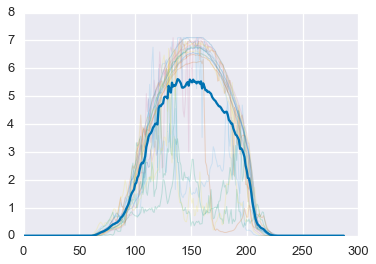

In [9]:
plt.plot(D[:, ics.test_days], linewidth=1, alpha=0.2)
plt.plot(np.average(D[:, ics.test_days], axis=1))
plt.show()

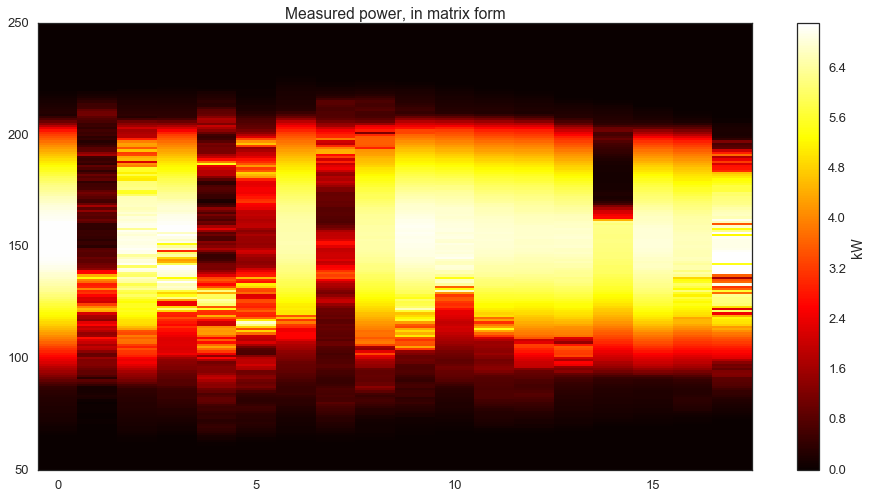

In [10]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(ics.D[:, ics.test_days], cmap='hot', aspect='auto', interpolation='none')
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')
    plt.ylim(50, 250)

In [11]:
ics.mu_L = 5e2
ics.mu_R = 1e3
ics.tau = 0.9
ics.minimize_objective(max_iter=12)

starting at 326428.672 [650.8028531031717, 318.1322943972495, 325459.73696755094, 0]
iteration 1: 355.048 [318.136   8.255  28.657   0.   ]
iteration 2: 327.853 [289.259   8.862  29.732   0.   ]
iteration 3: 324.611 [284.968   9.915  29.728   0.   ]
iteration 4: 323.815 [283.545  10.627  29.643   0.   ]
iteration 5: 323.388 [282.861  10.97   29.557   0.   ]
iteration 6: 323.070 [282.363  11.215  29.493   0.   ]
Minimization complete in 0.38 minutes


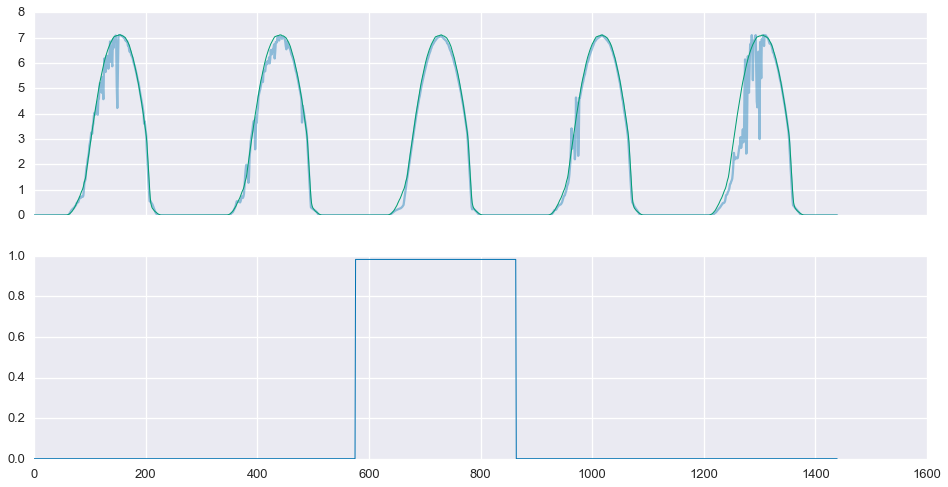

In [12]:
D1 = 20
D2 = D1+5
actual = p[D1*288:D2*288]
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F').A1
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)

In [13]:
clearsky = np.asarray(ics.L_cs.value.dot(ics.R_cs.value))

In [14]:
clearsky.shape

(288, 182)

In [15]:
ics.test_days
train_days = np.array(list(set(range(clearsky.shape[1])).difference(ics.test_days)))

In [16]:
daytime = np.logical_not(np.isclose(ics.D, 0, atol=1e-3))
residuals_train = ics.D[:, train_days][daytime[:, train_days]] - ics.L_cs.value.dot(ics.R_cs.value)[:, train_days][daytime[:, train_days]].A1
residuals_test = ics.D[:, ics.test_days][daytime[:, ics.test_days]] - ics.L_cs.value.dot(ics.R_cs.value)[:, ics.test_days][daytime[:, ics.test_days]].A1

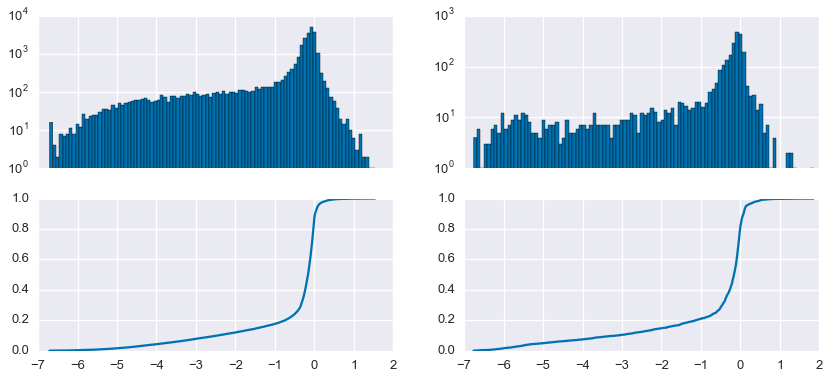

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

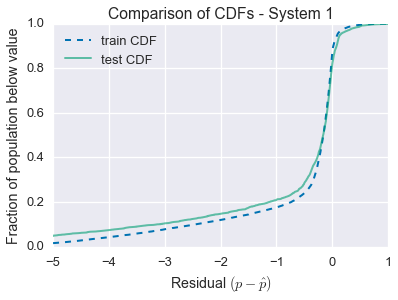

In [18]:
plt.plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-5, 1)
plt.title('Comparison of CDFs - System 1')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [19]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

In [20]:
stat, pval = kstest(residuals_test, cdf)
stat

0.06751878910196413

In [21]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print 'Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha)

Probability of incorrectly rejecting null hypothesis: 1.70e-10


## S07 - 3years of data

In [22]:
ti = time()
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADBC1078041')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)
df = make_time_series(df, return_keys=False).fillna(0)
days = df.resample('D').max().index[1:-1]
start = days[0].strftime('%m/%d/%y')
end = days[-1].strftime('%m/%d/%y')
tf = time()
print start, end
print 'data loading took {:.2f} seconds'.format(tf-ti)

04/25/15 05/21/18
data loading took 11.32 seconds


In [23]:
D = df.loc[start:end].as_matrix().reshape(288, -1, order='F')
p = df.loc[start:end]
ics = IterativeClearSky(D, k=5, reserve_test_data=0.1)

In [24]:
ics.test_days

array([   4,   11,   15,   35,   52,   62,   76,   77,   92,  115,  138,
        153,  158,  170,  171,  175,  176,  180,  197,  201,  220,  221,
        243,  246,  249,  257,  264,  279,  288,  298,  299,  300,  323,
        326,  348,  351,  374,  388,  400,  432,  437,  438,  448,  454,
        494,  501,  520,  541,  542,  546,  550,  559,  569,  587,  594,
        596,  600,  601,  605,  606,  616,  621,  629,  630,  638,  652,
        662,  669,  672,  673,  681,  689,  690,  695,  725,  726,  728,
        750,  755,  762,  763,  769,  786,  798,  801,  842,  849,  855,
        869,  885,  886,  893,  919,  924,  929,  934,  940,  964,  974,
        987,  993, 1000, 1013, 1025, 1028, 1029, 1039, 1051, 1061, 1069,
       1086, 1122])

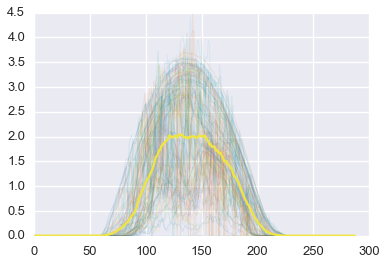

In [25]:
plt.plot(D[:, ics.test_days], linewidth=1, alpha=0.1)
plt.plot(np.average(D[:, ics.test_days], axis=1))
plt.show()

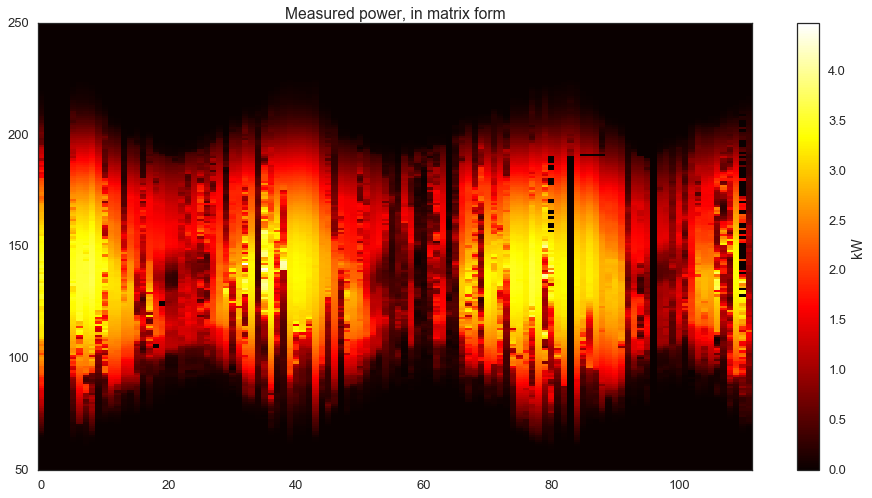

In [26]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(ics.D[:, ics.test_days], cmap='hot', interpolation='none', aspect='auto')
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')
    plt.ylim(50, 250)

In [27]:
ics.mu_L = 5e2
ics.mu_R = 1e3
ics.tau = 0.9
ics.minimize_objective(max_iter=8)

starting at 368422.300 [2186.2303750471174, 130.38163506531077, 366105.6882316694, 0]
iteration 1: 1640.141 [1430.82    15.405  193.917    0.   ]
iteration 2: 1384.752 [1184.553   14.507  185.692    0.   ]
iteration 3: 1356.055 [1156.218   18.448  181.389    0.   ]
iteration 4: 1348.717 [1151.619   19.476  177.622    0.   ]
iteration 5: 1344.887 [1149.822   19.91   175.155    0.   ]
iteration 6: 1342.275 [1148.946   20.158  173.171    0.   ]
iteration 7: 1340.334 [1148.565   20.34   171.43     0.   ]
iteration 8: 1338.669 [1148.2     20.553  169.916    0.   ]
Reached iteration limit. Previous improvement: 0.12%
Minimization complete in 3.80 minutes


In [28]:
train_days = np.array(list(set(range(clearsky.shape[1])).difference(ics.test_days)))

In [29]:
daytime = np.logical_not(np.isclose(ics.D, 0, atol=1e-3))
residuals_train = ics.D[:, train_days][daytime[:, train_days]] - ics.L_cs.value.dot(ics.R_cs.value)[:, train_days][daytime[:, train_days]].A1
residuals_test = ics.D[:, ics.test_days][daytime[:, ics.test_days]] - ics.L_cs.value.dot(ics.R_cs.value)[:, ics.test_days][daytime[:, ics.test_days]].A1

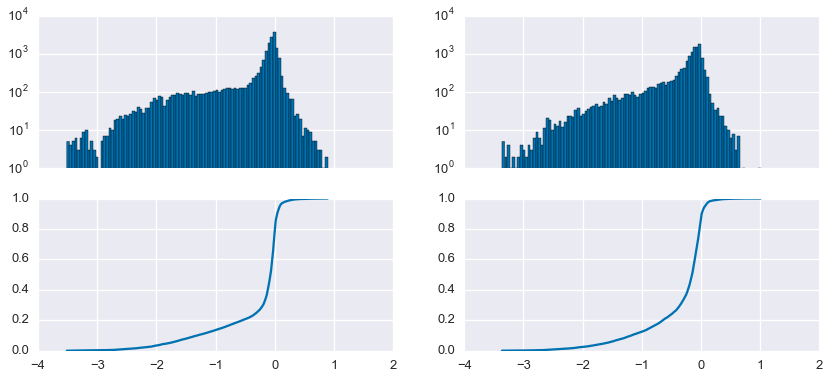

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

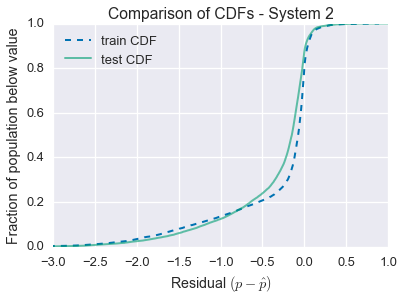

In [31]:
plt.plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-3, 1)
plt.title('Comparison of CDFs - System 2')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [32]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

In [33]:
stat, pval = kstest(residuals_test, cdf)
stat

0.17320319495912478

In [34]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print 'Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha)

Probability of incorrectly rejecting null hypothesis: 7.18e-214


# ERE Data - 1 Year

In [35]:
data = np.load('/Users/bennetmeyers/Documents/Data/collab/Huang_2017_data.npy')
p = data.ravel(order='F')

In [36]:
ics = IterativeClearSky(data, k=5, reserve_test_data=0.1)

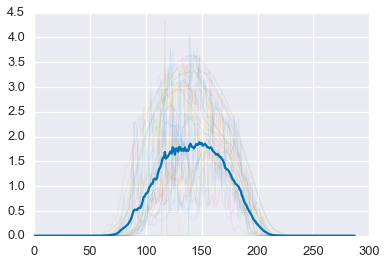

In [37]:
plt.plot(D[:, ics.test_days], linewidth=1, alpha=0.1)
plt.plot(np.average(D[:, ics.test_days], axis=1))
plt.show()

In [38]:
ics.mu_L = 1e4
ics.mu_R = 5e3
ics.tau = 0.9
ics.minimize_objective(max_iter=10)

starting at 18966408.683 [24481.09825041786, 5264.080113096101, 18936663.504533302, 0]
iteration 1: 16450.350 [14533.183    30.739  1886.428     0.   ]
iteration 2: 14612.148 [12815.122    44.774  1752.253     0.   ]
iteration 3: 13775.037 [11955.53     73.779  1745.727     0.   ]
iteration 4: 13637.194 [11822.069    76.299  1738.826     0.   ]
iteration 5: 13580.826 [11773.954    78.047  1728.825     0.   ]
iteration 6: 13542.824 [11742.713    79.579  1720.532     0.   ]
iteration 7: 13513.961 [11719.8      80.957  1713.204     0.   ]
iteration 8: 13489.276 [11699.818    81.761  1707.697     0.   ]
iteration 9: 13467.540 [11680.598    83.528  1703.415     0.   ]
iteration 10: 13449.415 [11662.812    85.172  1701.431     0.   ]
Reached iteration limit. Previous improvement: 0.13%
Minimization complete in 7.63 minutes


In [39]:
train_days = np.array(list(set(range(clearsky.shape[1])).difference(ics.test_days)))

In [40]:
daytime = ics.D >= 1e-3
residuals_train = ics.D[:, train_days][daytime[:, train_days]] - ics.L_cs.value.dot(ics.R_cs.value)[:, train_days][daytime[:, train_days]].A1
residuals_test = ics.D[:, ics.test_days][daytime[:, ics.test_days]] - ics.L_cs.value.dot(ics.R_cs.value)[:, ics.test_days][daytime[:, ics.test_days]].A1

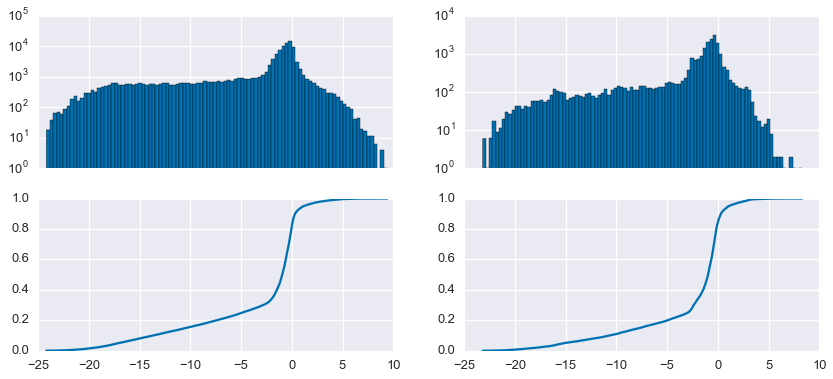

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

In [43]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

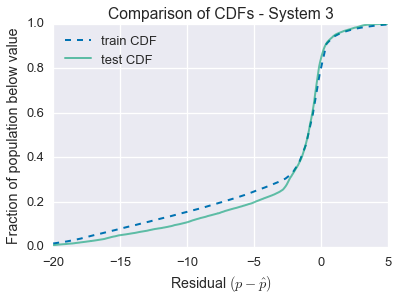

In [44]:
plt.plot(np.linspace(-20,5), cdf(np.linspace(-20,5)), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-20, 5)
plt.title('Comparison of CDFs - System 3')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [45]:
stat, pval = kstest(residuals_test, cdf)
stat

0.049049205127414286

In [46]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print 'Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha)

Probability of incorrectly rejecting null hypothesis: 3.88e-41
